# Random Forest and XGBoost

### The Data

One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases “kicks”.

Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.

Modelers who can figure out which cars have a higher risk of being kick can provide real value to dealerships trying to provide the best inventory selection possible to their customers.

The challenge of this competition is to **predict if the car purchased at the auction is a Kick (bad buy) or a good buy**.

- All the variables in the data set are defined in the file Carvana_Data_Dictionary.txt
- The data contains missing values
- The dependent variable (IsBadBuy) is binary (C2)
- There are 32 Independent variables (C3-C34)
- The data set is split to 60% training and 40% testing.

See more [here](https://www.kaggle.com/c/DontGetKicked/data?select=test.csv).

### Loading and preprocessing dataset

In [1]:
#!pip install -U seaborn
#!pip install numpy pandas matplotlib seaborn --quiet
#!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 7.9 MB/s eta 0:00:0000:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


Imports

In [2]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [4]:
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [5]:
train=pd.read_csv('training.csv')
test= pd.read_csv('test.csv')
train.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


### Exploratory Data Analysis

Understanding the manufacture year of the vehicles

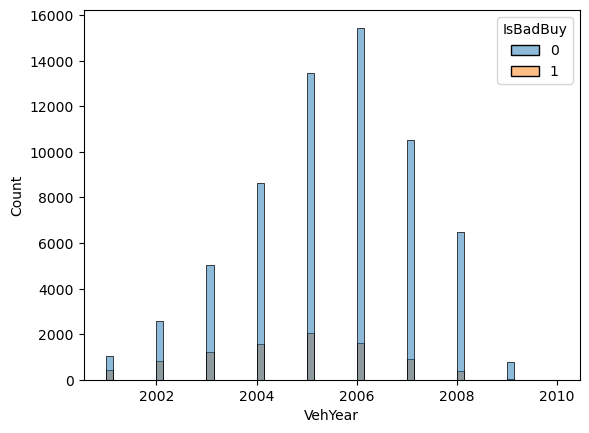

In [7]:
sns.histplot(data=train, x="VehYear", hue='IsBadBuy');

Checking if the auction has any influence or vehicle being bad

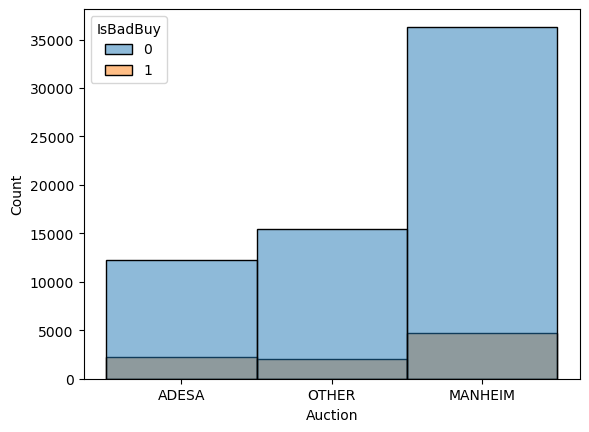

In [6]:
sns.histplot(data=train, x="Auction", hue='IsBadBuy');

Understanding the manufactures

In [8]:
train.Make.value_counts().head(10)

CHEVROLET    17248
DODGE        12912
FORD         11305
CHRYSLER      8844
PONTIAC       4258
KIA           2484
SATURN        2163
NISSAN        2085
HYUNDAI       1811
JEEP          1644
Name: Make, dtype: int64

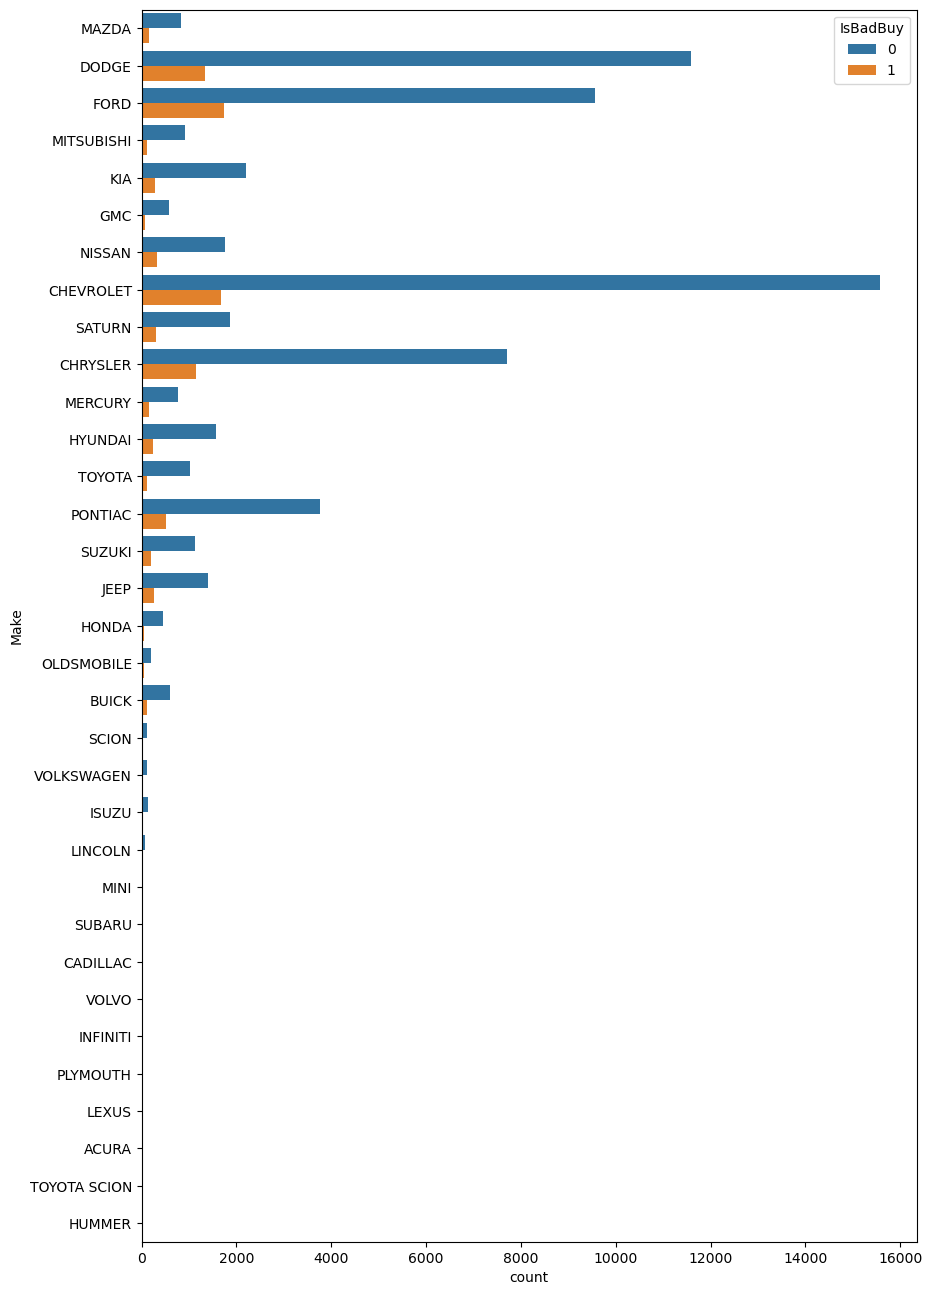

In [9]:
fig, ax = plt.subplots(figsize=(10,16))
sns.countplot(y="Make", data=train, hue='IsBadBuy')
plt.show()

Impact of color of car being kicked or not

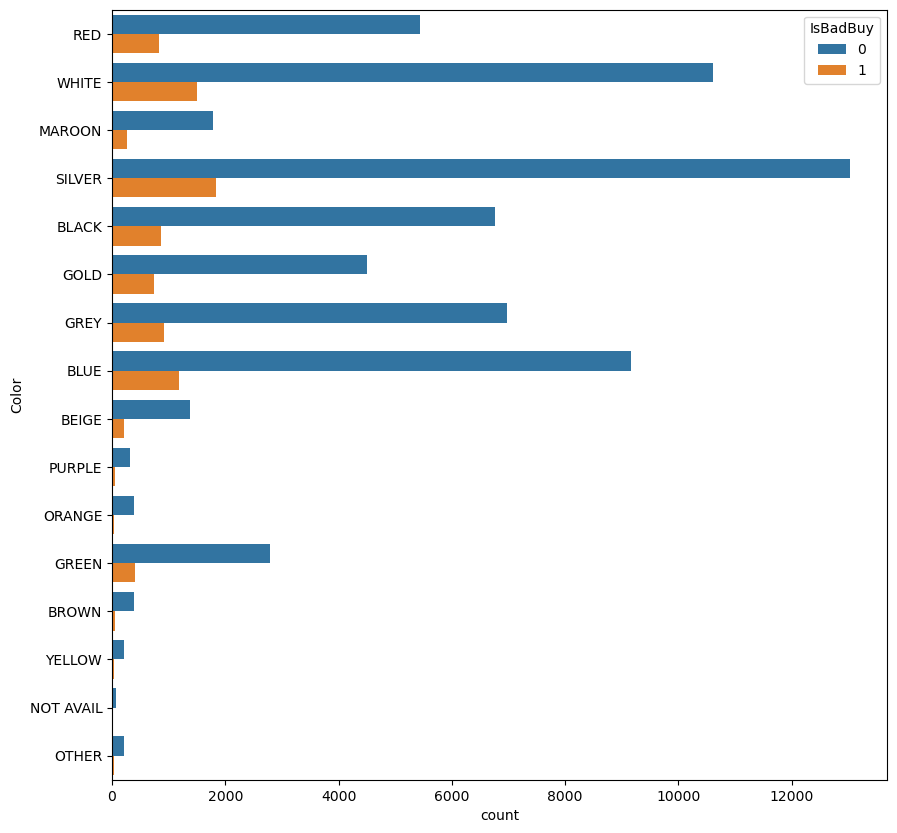

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y="Color", data=train, hue='IsBadBuy')
plt.show()

Impact of transmission type on kicked cars

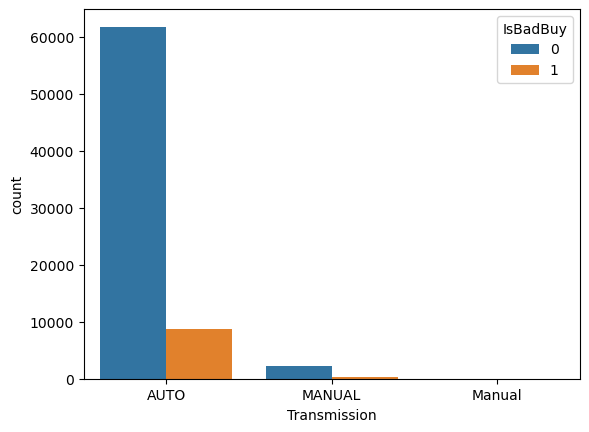

In [11]:
sns.countplot(x="Transmission", data=train, hue='IsBadBuy');

### Feature Engineering

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

In [13]:
print(train.isnull().sum())

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentA

In [13]:
print(test.isnull().sum())

RefId                                    0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1550
SubModel                                 5
Color                                    4
Transmission                             3
WheelTypeID                           2188
WheelType                             2188
VehOdo                                   0
Nationality                              7
Size                                     7
TopThreeAmericanName                     7
MMRAcquisitionAuctionAveragePrice       10
MMRAcquisitionAuctionCleanPrice         10
MMRAcquisitionRetailAveragePrice        10
MMRAcquisitonRetailCleanPrice           10
MMRCurrentAuctionAveragePrice          143
MMRCurrentAuctionCleanPrice            143
MMRCurrentR

Checking duplicates

In [14]:
train[train.duplicated()]

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost


In [15]:
test[test.duplicated()]

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost


**Drop** since they not seem relevant as they contain specific details which may not help model to learn better

- PurchDate (Date might not be relevant but Year would be)
- WheelTypeID
- Model
- Trim
- SubModel
- Make
- VNZIP1
- VNST

**Create** additional features

In [16]:
def split_date(df):
    df['PurchDate'] = pd.to_datetime(df[ 'PurchDate' ])
    df['Year'] = df.PurchDate.dt.year

In [27]:
def MeanOnFeatures(df):
    df['mean_MMRCurrentAuctionAveragePrice_Make' ]=train.groupby(['Make' ])['MMRCurrentAuctionAveragePrice'].transform( 'mean' )
    df['mean_MMRCurrentAuctionAveragePrice_Model']=train.groupby(['Model'])['MMRCurrentAuctionAveragePrice' ].transform('mean')
    df['mean_MMRCurrentAuctionAveragePrice_Trim' ]=train.groupby(['Trim' ])['MMRCurrentAuctionAveragePrice' ].transform( 'mean' )
    df['mean_MMRCurrentAuctionAveragePrice_SubModel ' ]=train.groupby(['SubModel']) ['MMRCurrentAuctionAveragePrice' ].transform('mean')
    df['mean_MMRCurrentAuctionAveragePrice_Color' ]=train.groupby(['Color'])['MMRCurrentAuctionAveragePrice' ].transform( 'mean' )
    df['mean_MMRCurrentAuctionAveragePrice_Transmission' ]=train.groupby(['Transmission' ])['MMRCurrentAuctionAveragePrice' ].transform('mean')

In [28]:
print(train.shape, test.shape)

(72983, 37) (48707, 34)


In [29]:
split_date(train)
split_date(test)

print(train.shape, test.shape)

MeanOnFeatures(train)
MeanOnFeatures(test)

(72983, 37) (48707, 34)


In [20]:
print(train.shape, test.shape)

(72983, 41) (48707, 40)


Handling NaN

In [20]:
train.isnull().sum()

RefId                                          0
IsBadBuy                                       0
PurchDate                                      0
Auction                                        0
VehYear                                        0
VehicleAge                                     0
Make                                           0
Model                                          0
Trim                                        2360
SubModel                                       8
Color                                          8
Transmission                                   9
WheelTypeID                                 3169
WheelType                                   3174
VehOdo                                         0
Nationality                                    5
Size                                           5
TopThreeAmericanName                           5
MMRAcquisitionAuctionAveragePrice             18
MMRAcquisitionAuctionCleanPrice               18
MMRAcquisitionRetail

In [31]:
train.Transmission.value_counts()

AUTO      70398
MANUAL     2575
Manual        1
Name: Transmission, dtype: int64

In [32]:
# Merge MANUAL and Manual
train["Transmission"].replace("Manual", "MANUAL", inplace=True)

Target, isBadBuy, is unbalanced

In [33]:
train.IsBadBuy.value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

0    64007
1    64007
Name: IsBadBuy, dtype: int64


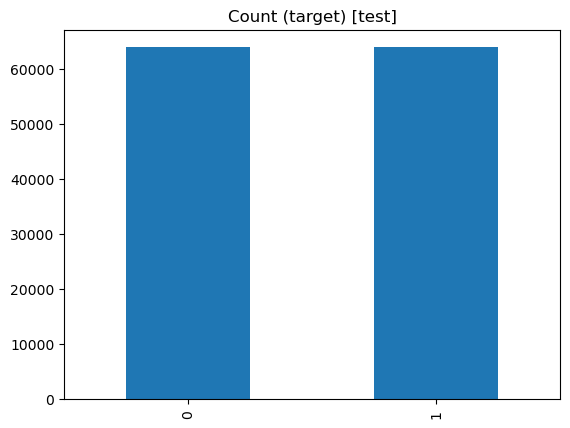

In [34]:
count_class_0, count_class_1 = train.IsBadBuy.value_counts()

#separate by value
df_class_0 = train[train['IsBadBuy'] == 0]
df_class_1 = train[train['IsBadBuy'] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print(df_test_over.IsBadBuy.value_counts())

df_test_over.IsBadBuy.value_counts().plot(kind='bar', title='Count (target) [test]');

### Data Cleaning and Splitting

Preparation for splitting

In [35]:
#create X and y datasets for splitting 
X = df_test_over.drop(["RefId",'IsBadBuy'], axis=1)
y = df_test_over['IsBadBuy']

In [37]:
all_features = X.columns
all_features = all_features.tolist()

In [38]:
numerical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind in ['i','f']]
categorical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind not in ['i','f']]

Splitting

In [39]:
#import train_test_split library
from sklearn.model_selection import train_test_split

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Implementing **Random Forest**

In [43]:
preprocessor = make_column_transformer(
    (make_pipeline(
        SimpleImputer(strategy = 'median'),
        #KNNImputer(n_neighbors=2, weights="uniform"),
        MinMaxScaler()
    ),
     numerical_features),
    (make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value='missing'),
        OneHotEncoder(categories= 'auto', handle_unknown='ignore')
    ),
        categorical_features)
)

In [44]:
preprocessor_best = make_pipeline(
    preprocessor,
    VarianceThreshold(),
    SelectKBest(f_classif, k=50)
)

In [45]:
RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators = 100))

In [47]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

1.0

In [49]:
RF_Model.score(X_test, y_test)

0.9831792735320922

The model has learned the training examples excellently and doesn’t generalize well to previously unseen examples. To resolve oversampling, it was induced some overlaps between testing and training set - hence is is observed a very high accuracy - **“overfitting”**

Two possible solutions:

- Hyperparameter tuning to overcome the overfitting.
- Instead of splitting the data into train and testing set, let us train on the entire set in one go - K-fold cross validation.

### Hyperparameter Tuning — Random Forest

In [50]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 19)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

#Maximum number of levels in tree
max_depth = [2,4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [51]:
# Create the param grid
param_grid = {'randomforestclassifier__n_estimators': n_estimators,
              'randomforestclassifier__max_features': max_features,
              'randomforestclassifier__max_depth': max_depth,
              'randomforestclassifier__min_samples_split': min_samples_split,
              'randomforestclassifier__min_samples_leaf': min_samples_leaf,
              'randomforestclassifier__bootstrap': bootstrap
             }
print(param_grid)

{'randomforestclassifier__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'randomforestclassifier__max_features': ['auto', 'sqrt'], 'randomforestclassifier__max_depth': [2, 4, 6, 8], 'randomforestclassifier__min_samples_split': [2, 5], 'randomforestclassifier__min_samples_leaf': [1, 2], 'randomforestclassifier__bootstrap': [True, False]}


In [52]:
from sklearn.model_selection import RandomizedSearchCV

rf_RandomGrid = RandomizedSearchCV(estimator = RF_Model, param_distributions = param_grid, cv = 3, verbose=1, n_jobs = -1, n_iter = 5, scoring = 'f1')

In [53]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/miguel/miniconda3/envs/daa/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/miguel/miniconda3/envs/daa/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/miguel/miniconda3/envs/daa/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remo

CPU times: user 52.4 s, sys: 520 ms, total: 52.9 s
Wall time: 3min 23s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                ['VehYear',
                                                                                                 'VehicleAge',
                                                                                                 'WheelTypeID',
                                                                                                 'VehOdo',
                                                                                                 'MMRAcquisitionAuctionAveragePrice',
                                                                                                 'MMRAcquisitionAuctio...
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': [2,
                                                                              4,
                                                                              6,
                                                                              8],
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5],
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 150,
                                                                                 200,
                                                                                 250,
                                                                                 300,
                                                                                 350,
                                                                                 400,
                                                                                 450,
                                                                                 500,
                                                                                 550,
                                                                                 600,
                                                                                 650,
                                                                                 700,
                                                                                 750,
                                                                                 800,
                                                                                 850,
                                                                                 900

In [54]:
rf_RandomGrid.score(X_train, y_train)

0.6823491389260816

In [55]:
rf_RandomGrid.score(X_test, y_test)

0.6773671432425141

Overfitting reduced

In [56]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['VehYear',
                                                                    'VehicleAge',
                                                                    'WheelTypeID',
                                                                    'VehOdo',
                                                                    'MMRAcquisitionAuctionAveragePrice',
                                                                    'MMRAcquisitionAuctionCleanPrice',
                                                                    'MMRAcquisitionRetail...
                                                                    'Model',
                                                                    'Trim',
                                                                    'SubModel',
                                                                    'Color',
                                                                    'Transmission',
                                                                    'WheelType',
                                                                    'Nationality',
                                                                    'Size',
                                                                    'TopThreeAmericanName',
                                                                    'PRIMEUNIT',
                                                                    'AUCGUART',
                                                                    'VNST'])])),
                                 ('variancethreshold', VarianceThreshold()),
                                 ('selectkbest', SelectKBest(k=50))])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='auto',
                                        min_samples_split=5,
                                        n_estimators=350))])

Accuracy

In [57]:
print(f'Train : {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test : {rf_RandomGrid.score(X_test, y_test):.3f}')

Train : 0.682
Test : 0.677


It is a generalized model

### Implementing **XGBoost**

In [60]:
preprocessor = make_column_transformer(
    (make_pipeline(
        #SimpleImputer(strategy = 'median')
        KNNImputer(n_neighbors=2, weights="uniform"),
        MinMaxScaler()),
     numerical_features),
    (make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value='missing'),
        OneHotEncoder(categories= 'auto', handle_unknown='ignore')
    ),
        categorical_features)
)

preprocessor_best = make_pipeline(
    preprocessor,
    VarianceThreshold(),
    SelectKBest(f_classif, k=50)
)

<code>class xgboost.**XGBClassifier**<\code>(\*, objective='binary:logistic', use_label_encoder=None, **kwargs)

In [61]:
from xgboost import XGBClassifier
import xgboost as xgb
XG_Model = make_pipeline(preprocessor_best, XGBClassifier(n_estimators = 100))

In [62]:
%%time
XG_Model.fit(X, y)

CPU times: user 9min 22s, sys: 1min 30s, total: 10min 52s
Wall time: 4min 32s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer(n_neighbors=2)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['VehYear',
                                                                    'VehicleAge',
                                                                    'WheelTypeID',
                                                                    'VehOdo',
                                                                    'MMRAcquisitionAuctionAveragePrice',
                                                                    'MMRAcquisitionAuctionCleanPrice',
                                                                    'MMRAcquisitionRetailAveragePri...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [63]:
XG_Model.score(X, y)

0.8369240864280469

K Fold Cross Validation

In [64]:
from sklearn.model_selection import KFold

In [65]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = make_pipeline(
        preprocessor_best,
        XGBClassifier(random_state=42, n_jobs=-1, **params)
    )
    model.fit(X_train, train_targets)
    train_accuracy = model.score(X_train, train_targets)
    val_accuracy = model.score(X_val, val_targets)
    return model, train_accuracy, val_accuracy

In [68]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [69]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
    model, train_accuracy, val_accuracy = train_and_evaluate(X_train, 
                                                            train_targets, 
                                                            X_val, 
                                                            val_targets, 
                                                            max_depth=4, 
                                                            n_estimators=20)
    models.append(model)
    print('Train Accuracy: {}, Validation Accuracy: {}'.format(train_accuracy, val_accuracy))

KeyboardInterrupt: 

The train accuracy is high and the validation accuracy is low.
Let's create an average of the 5 models so the errors can be reduced.

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
preds = predict_avg(models, test.reindex([1,31]))

### Hyperparameter Tuning — XGBoost

In [ ]:
def test_params_kfold(n_splits, **params):
    train_accuracys, val_accuracys, models = [], [], []
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
        model, train_accuracy, val_accuracy = train_and_evaluate(X_train, 
                                                                train_targets, 
                                                                X_val, 
                                                                val_targets, 
                                                                **params)
        models.append(model)
        train_accuracys.append(train_accuracy)
        val_accuracys.append(val_accuracy)
    print('Train accuracy: {}, Validation accuracy: {}'.format(np.mean(train_accuracys), np.mean(val_accuracys)))
    return models

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=10)

In [ ]:
#test_params_kfold(5, n_estimators=100)

In [ ]:
#test_params_kfold(5, n_estimators=240)

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=500)

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=500, max_depth=2)

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=500, max_depth=4)

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=500, max_depth=6)

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.01)

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.1)

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.3)

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.9)

In [ ]:
#%%time
#test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.99)

In [ ]:
#Putting it all together
XG_model_with_paramter_tuning = make_pipeline(
    preprocessor_best,
    XGBClassifier(random_state=42, n_jobs=-1, n_estimators=500, max_depth=6, learning_rate=0.9)
)

XG_model_with_paramter_tuning.fit(X,y)

### Sample Prediction and Saving the model

In [60]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    pred = rf_RandomGrid.predict(input_df)
    prob = rf_RandomGrid.predict_proba(input_df)[0]
    return pred, prob[0]

In [61]:
new_input = {'RefId':48708,
             'PurchDate':2001-12-2,
             'Auction':'ADESA',
             'VehYear':2004,
             'VehicleAge':6,
             'Make':'DODGE',
             'Model':'DURANGO 2WD V8',
             'Trim':'Adv',
             'SubModel':'4D SUV 4.7L ADVENTURER',
             'Color':'SILVER',
             'Transmission':'AUTO',
             'WheelTypeID':1.0,
             'WheelType':'Alloy',
             'VehOdo':33333,
             'Nationality':'TOP LINE ASIAN',
             'Size':'MEDIUM',
             'TopThreeAmericanName':'OTHER',
             'MMRAcquisitionAuctionAveragePrice':7777, 
             'MMRAcquisitionAuctionCleanPrice':8888,
             'MMRAcquisitionRetailAveragePrice':10000, 
             'MMRAcquisitonRetailCleanPrice':12000,
             'MMRCurrentAuctionAveragePrice':7777, 
             'MMRCurrentAuctionCleanPrice':9999,
             'MMRCurrentRetailAveragePrice':11111, 
             'MMRCurrentRetailCleanPrice':11111,
             'PRIMEUNIT':'NaN', 
             'AUCGUART':'NaN', 
             'BYRNO':17777, 
             'VNZIP1': 30212,
             'VNST':'GA',             
             'VehBCost':7777, 
             'IsOnlineSale':0,
             'WarrantyCost':600, 
             'Year':2010, 
             'mean_MMRCurrentAuctionAveragePrice_Make':7021.627649,
             'mean_MMRCurrentAuctionAveragePrice_Model':7091.0279,
             'mean_MMRCurrentAuctionAveragePrice_Trim':6171.007828,
             'mean_MMRCurrentAuctionAveragePrice_SubModel':5577.972891,
             'mean_MMRCurrentAuctionAveragePrice_Color':6794.120395,
             'mean_MMRCurrentAuctionAveragePrice_Transmission':6180.060667}

In [62]:
predict_input(rf_RandomGrid, new_input)

(array([0]), 0.6534384764915909)

Saving the model

In [63]:
import joblib
car_quality_check = {
    'model': rf_RandomGrid
}

joblib.dump(car_quality_check, 'car_quality_check.joblib')

['car_quality_check.joblib']

In [64]:
car_quality_check2 = joblib.load('car_quality_check.joblib')

In [65]:
test_preds2 = car_quality_check2['model'].score(X_test, y_test)
print('Test accuracy: {}'.format(test_preds2:.3f))

Accuracy of the model Random forest is 0.670
